<a href="https://colab.research.google.com/github/Ankita-Phd/Ankita/blob/main/Module_Project11_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy  as np
import scipy.integrate

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import copy
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.linear_model  import LinearRegression, BayesianRidge
from   sklearn.tree          import DecisionTreeRegressor
from   sklearn.preprocessing import PolynomialFeatures

In [2]:
path = "https://raw.githubusercontent.com/PranavTadimeti/Regression_Project/main/covid_19_data.csv"
df_orig = pd.read_csv(path)
print(df_orig.head())

   SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


In [6]:
df = copy.deepcopy(df_orig)
df.drop('Last Update',inplace=True,axis=1)
date_lst  = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp

In [7]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp

In [8]:
df_date_tots = pd.DataFrame(date_tot_tup_dict)
df_date_tots = df_date_tots.transpose()
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
print(df_date_tots)

            Confirmed   Deaths  Recovered
01/22/2020      555.0     17.0       28.0
01/23/2020      653.0     18.0       30.0
01/24/2020      941.0     26.0       36.0
01/25/2020     1438.0     42.0       39.0
01/26/2020     2118.0     56.0       52.0
...               ...      ...        ...
03/27/2020   593291.0  27198.0   130915.0
03/28/2020   660706.0  30652.0   139415.0
03/29/2020   720117.0  33925.0   149082.0
03/30/2020   782365.0  37582.0   164566.0
03/31/2020   857487.0  42107.0   178034.0

[70 rows x 3 columns]


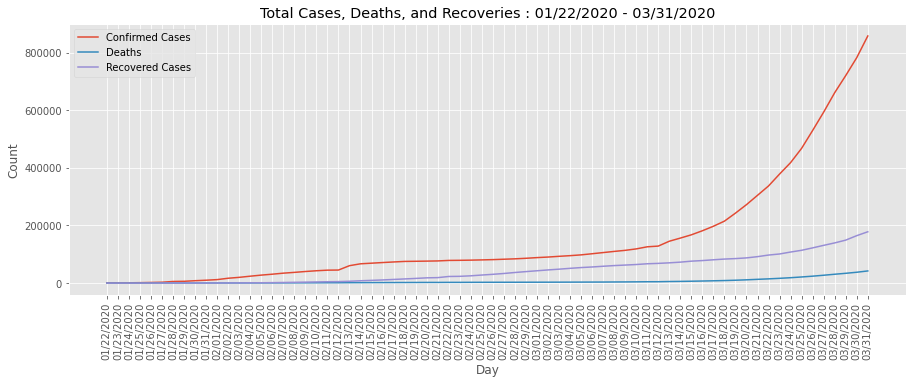

In [9]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases")
plt.plot(df_date_tots['Deaths'], label    = "Deaths")
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);


In [11]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']

In [12]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']

In [13]:
days_since_lst = []
for i in range(len(date_lst)):
    days_since_lst.append(i)
df_date_tots["Days Since:"] = days_since_lst
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]]

In [14]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
y = np.array(df_date_tots["Confirmed"])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

In [16]:
def cal_cost(y_pred, X, y):
    '''
    Calculates the cost for given X and Y.
    y_pred = Vector of y_preds 
    X = Row of X's np.zeros((2, j))
    y = Actual y's np.zeros((2, 1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(y_pred)
    cost = (1 / 2 * m) * np.sum(np.square(predictions - y))

    return cost

In [39]:
def gradient_descent(X, y, y_pred, learning_rate=0.01, iterations=1000):
    '''
    X = Matrix of X with added bias units
    y = Vector of Y
    y_pred = Vector of y_preds np.random.randn(j, 1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final y_pred vector and array of cost history over no of iterations
    '''

    m = len(y)
    cost_history = np.zeros(1000, 1)
    y_pred_history = np.zeros((1000, 1))
    
    for it in range(1000):    
        prediction = np.dot(X, y_pred)
        y_pred = y_pred - (1 / m) * learning_rate * (X.T.dot((prediction - y)))
        y_pred_history[it,:] = y_pred.T
        cost_history[it]  = cal_cost(y_pred, X, y)
        
    return y_pred, cost_history, y_pred_history    

In [29]:
print(y_pred)

[[ 3.54606154e+00 -5.94295184e-01]
 [-1.38399473e+00  1.49069508e+00]
 [ 2.50473971e-01 -1.90501143e+00]
 [-7.06877507e-01  9.82567567e-01]
 [-2.45687735e-01 -9.59811430e-01]
 [ 4.72959866e-01  6.88933223e-03]
 [ 4.88514783e-01 -1.53753839e+00]
 [ 6.23831247e-01 -3.78115803e-01]
 [ 1.63017207e+00 -1.61142541e-01]
 [-6.42898641e-01  5.34726478e-01]
 [-1.01509714e+00  4.10612092e-01]
 [-3.31414864e-01 -3.92391304e-01]
 [ 8.13259454e-03 -8.74073671e-01]
 [-1.79013085e+00 -6.55091021e-01]
 [-2.11356928e-02  4.16022933e-01]
 [ 3.02190753e-01 -6.96271628e-01]
 [-1.22443124e-03  1.73814978e+00]
 [ 1.00891867e+00  2.34748445e+00]
 [ 4.84324673e-01  4.85136474e-01]
 [-9.10397515e-01  9.41121139e-01]
 [-9.80849513e-01 -3.44348699e-01]
 [-2.31195794e-01  1.37278406e+00]
 [-6.42631155e-02  1.33405213e-02]
 [ 1.38953810e+00  8.35744755e-01]
 [ 6.31180959e-01 -4.90329467e-01]
 [-1.00348253e+00 -6.78673992e-01]
 [ 8.94717972e-02 -3.74298142e-02]
 [-1.10567652e-01  4.40796095e-01]
 [ 1.99182272e+00 -8